In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from modules.neqr import neqr
from modules.ladder import ladder_up
from modules.enhanced_grover import filter_oracle
from modules.qsubtract import subtract
from modules.qadd import qft_adder
from modules.copy import copy
from modules.threshold import threshold
from modules.shift_edge import shift_edge
from PIL import Image
import numpy as np

In [2]:
num_bits = 1
intensity_bits =  1
threshold_x = "0"
threshold_y = "0"

image = np.array([
    [0,0],
    [0,1]
])


In [3]:
# def pad_image(image, target_shape=None):
#     h, w = image.shape
#     # Default: pad to 2× height and 2× width
#     if target_shape is None:
#         target_shape = (2 * h, 2 * w)
#     new_h, new_w = target_shape
#     pad_top = (new_h - h) // 2
#     pad_bottom = new_h - h - pad_top
#     pad_left = (new_w - w) // 2
#     pad_right = new_w - w - pad_left
#     padded = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=2**intensity_bits-1)
#     return padded
# def load_image(filepath, size=(16, 16)):
#     img = Image.open(filepath).convert('L')  # Grayscale
#     img = img.resize(size, Image.Resampling.LANCZOS)
#     img_array = np.array(img)
#     return img_array
# def normalize_image(image, bits=3):
#     max_val = 2**bits - 1
#     return np.round((image / 255) * max_val).astype(int)
# image = load_image('images/heartimg.png',size=(16,16))
# image = normalize_image(image, bits=3)
# image = pad_image(image)
# print(image)
# np.savetxt("normalized_image.txt", image, fmt='%d')


In [4]:
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
grad1 = QuantumRegister(intensity_bits, name='GradX')
sign1 = QuantumRegister(1, name='signX')
sign2 = QuantumRegister(1, name='signY')
oracle_x = QuantumRegister(1, name='oracle_x')
oracle_y = QuantumRegister(1, name='oracle_y')
a1 = QuantumRegister(1, name='a1')
a2 = QuantumRegister(1, name='a2')
output = QuantumRegister(1, name='output')
cr = ClassicalRegister(num_bits * 2 + 1, name='c')  

qc = QuantumCircuit(x, y, i1, i2, grad1, sign1, sign2, a1, a2, oracle_x, oracle_y, output, cr)

In [5]:
# Superposition across all position values
qc.h(x)
qc.h(y)

In [6]:
# x gradient

neqr_gate1 = neqr(i1,x,y,image)
qc.append(neqr_gate1, list(i1) + list(x) + list(y))

# Shift up: ladder_up
ladder = ladder_up(x)
qc.append(ladder, list(x))

qc.append(neqr_gate1, list(i2) + list(x) + list(y))


copy_gate = copy(list(i2), list(grad1))
qc.append(copy_gate, list(i2) + list(grad1))

qc.barrier(label='1')

sub1 = subtract(i1, grad1, sign1)
qc.append(sub1, list(i1) + list(grad1) + list(sign1))

qc.barrier(label='2')
neqr1_inverse = neqr_gate1.inverse()
neqr1_inverse.name = "NEQR†"

qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

ladder_down = ladder.inverse()
ladder_down.name = "a"
qc.append(ladder_down,list(x))
qc.barrier(label='3')

shift_edgex = shift_edge(x,sign1,a1)

qc.append(shift_edgex, list(x) + list(sign1) + list(a1))

qc.barrier(label='4')
threshold_x_gate = threshold(oracle_x,sign1,grad1,a1,threshold_x)

qc.append(threshold_x_gate, list(oracle_x) + list(sign1) + list(grad1) + list(a1))
qc.barrier(label='5')

1
[0]
0 0


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=12, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "x"), index=0>, <Qubit register=(1, "y"), index=0>, <Qubit register=(1, "I₁"), index=0>, <Qubit register=(1, "I₂"), index=0>, <Qubit register=(1, "GradX"), index=0>, <Qubit register=(1, "signX"), index=0>, <Qubit register=(1, "signY"), index=0>, <Qubit register=(1, "a1"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "oracle_x"), index=0>, <Qubit register=(1, "oracle_y"), index=0>, <Qubit register=(1, "output"), index=0>), clbits=())

In [7]:
# Y Gradient



qc.append(ladder, list(y))


qc.append(neqr_gate1, list(i2) + list(x) + list(y))

qc.append(sub1, list(i1) + list(i2) + list(sign2))
qc.append(ladder_down,list(y))

shift_edgey = shift_edge(y,sign2,a2)

qc.append(shift_edgey, list(y) + list(sign2) + list(a2))



threshold_y_gate = threshold(oracle_y,sign2,i2,a2,threshold_y)

qc.append(threshold_y_gate, list(oracle_y) + list(sign2) + list(i2) + list(a2))


1
[0]
0 0


In [8]:
qc.barrier(label='6')


qc.cx(oracle_x, output)
qc.cx(oracle_y, output)
qc.ccx(oracle_x, oracle_y, output)

qc.barrier(label='7')

qc.measure(list(x) + list(y) + list(output), list(cr))

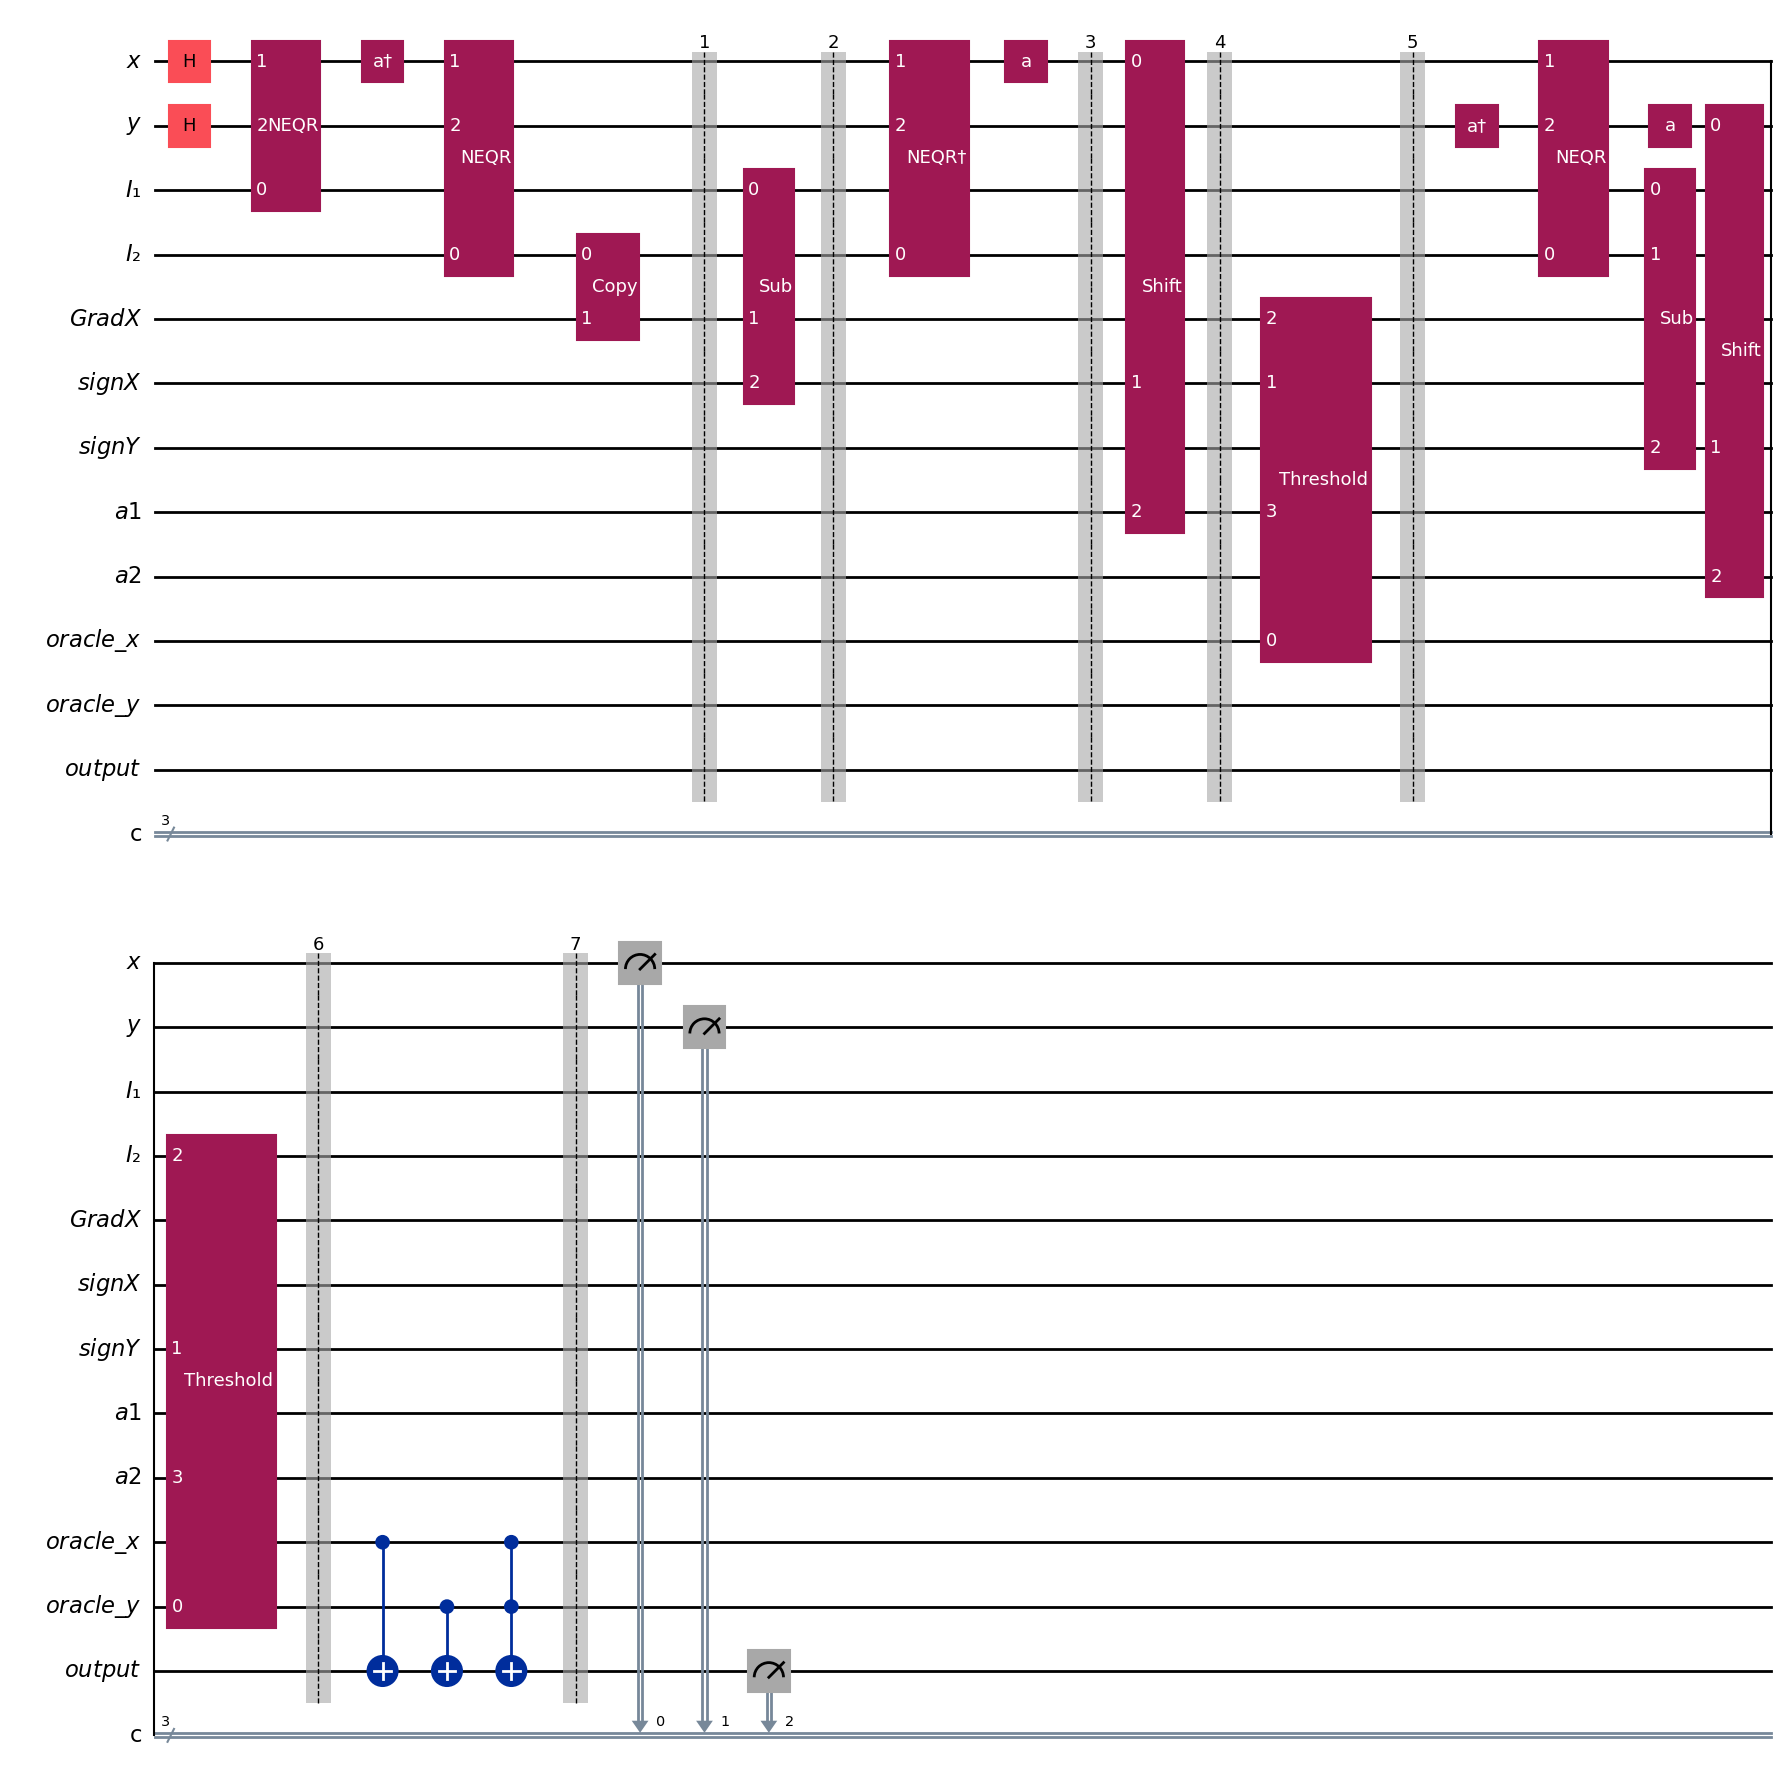

In [9]:
qc.draw('mpl')

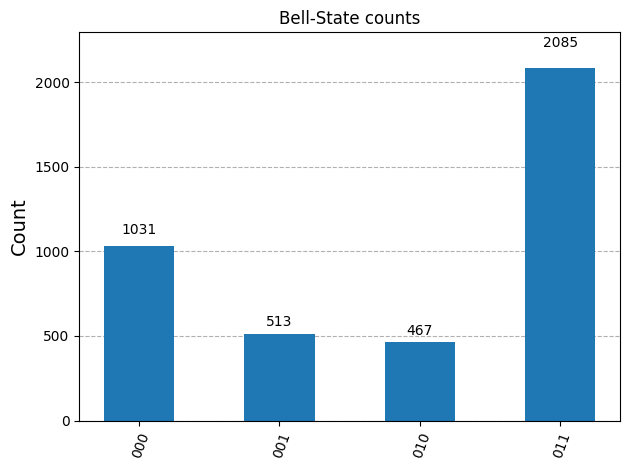

In [10]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ, shots=4096).result()
counts = result.get_counts()
plot_histogram(counts, title='Bell-State counts')

In [11]:
dim = 2**num_bits
edge_img = np.zeros((dim, dim), dtype=int)
for qstate, count in counts.items():

    intensity_bin = qstate[:1]
    y_bin = qstate[1:1 + num_bits]
    x_bin = qstate[1 + num_bits:1 + 2*num_bits]

    intensity = int(intensity_bin,2)
    if intensity == 1:  
        y = int(y_bin, 2)
        x = int(x_bin, 2)

        edge_img[y, x] = intensity
        
print(edge_img)

[[0 0]
 [0 0]]


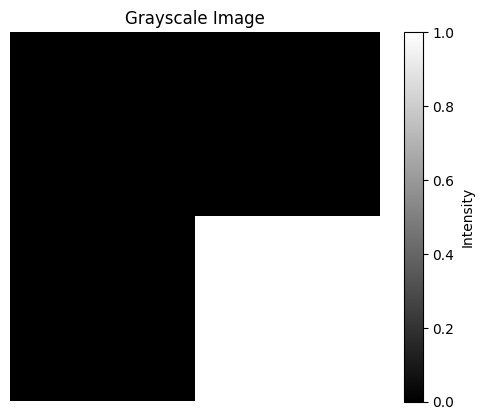

In [12]:
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Grayscale Image')
plt.axis('off')  # Hide axis ticks
plt.show()


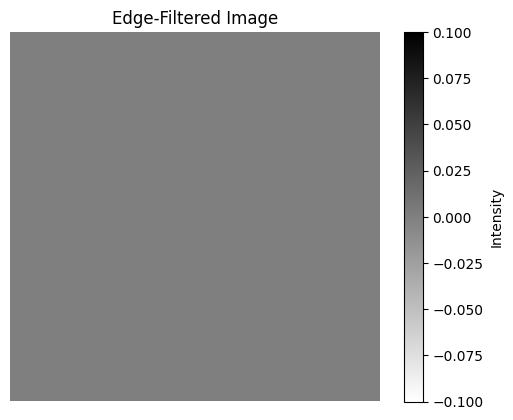

In [13]:
plt.imshow(edge_img, cmap='gray_r', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Edge-Filtered Image')
plt.axis('off')
plt.show()